# Final Project - CSI4106
Group: project_14

 Tristan Pender - 300065847 - tpend052@uottawa.ca

 Rafael Villacorta - 300061289 - rvill094@uottawa.ca
 
 Hans Barrera - 300080843 - hbarr050@uottawa.ca

In [89]:
import numpy as np
import tensorflow as tf
import random as python_random
import pandas as pd
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import datetime
import os
# for reproducibility purposes
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# load tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 26629), started 1 day, 21:53:45 ago. (Use '!kill 26629' to kill it.)

#### Data loading

In [90]:
# load the dataset
df = pd.read_csv('./data/rideshare_kaggle.csv')

# print the dimensionality of the dataframe
print(df.shape,"\n")
# print the names of the columns that can be used as features when training the machine learning model
print(df.columns,"\n")
# rename columns and print the new names of the columns to allow for future manipulation of dataframe
for column in df.columns:
    new_title = column
    if ' ' in column:
        new_title = new_title.replace(" ", "_")
    if '(' in column:
        new_title = new_title.replace("(", "as_")
        new_title = new_title.replace(")", "")
    if '%' in column:
        new_title = new_title.replace("%", "pct")
    if '+' in column:
        new_title = new_title.replace("+", "plus")
    if ',' in column:
        new_title = new_title.replace(",", "")
    if '-' in column:
        new_title = new_title.replace("-", "_to_")
    if '$' in column:
        new_title = new_title.replace("$", "_dollars")
    df.rename({column: new_title}, axis=1, inplace=True)     

(693071, 57) 

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'a

#### Exploratory analysis

In [91]:
df = df.dropna()
# Exploratory analysis
print(f"dataframe shape:\n{df.shape}\n")
print(f"dataframe columns:\n{df.columns}\n")
print(f"dataframe sample:\n{df.head()}\n")

dataframe shape:
(637976, 57)

dataframe columns:
Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'app

In [92]:
print(f"value counts:\n{df['datetime'].value_counts()}\n")
print(f"value counts:\n{df['timezone'].value_counts()}\n")
print(f"value counts:\n{df['source'].value_counts()}\n")
print(f"value counts:\n{df['destination'].value_counts()}\n")
print(f"value counts:\n{df['cab_type'].value_counts()}\n")
print(f"value counts:\n{df['product_id'].value_counts()}\n")
print(f"value counts:\n{df['short_summary'].value_counts()}\n")



value counts:
2018-11-26 23:33:14    151
2018-11-29 02:29:08    149
2018-11-29 02:47:08    146
2018-11-27 00:03:14    146
2018-11-29 04:38:08    146
                      ... 
2018-12-03 07:33:03      3
2018-11-30 21:33:07      3
2018-12-15 06:05:07      3
2018-12-13 15:10:13      1
2018-11-30 13:17:58      1
Name: datetime, Length: 31350, dtype: int64

value counts:
America/New_York    637976
Name: timezone, dtype: int64

value counts:
Financial District         54197
Back Bay                   53201
Theatre District           53201
Boston University          53172
North End                  53171
Fenway                     53166
Northeastern University    53164
South Station              53160
Haymarket Square           53147
West End                   52980
Beacon Hill                52841
North Station              52576
Name: source, dtype: int64

value counts:
Financial District         54192
Back Bay                   53190
Theatre District           53189
Haymarket Square      

Transforming categorical data

In [93]:
df.short_summary.value_counts()
df.long_summary.value_counts()
df.icon.value_counts()

 cloudy                  201429
 partly-cloudy-night     145492
 partly-cloudy-day       106337
 rain                     96170
 clear-night              55577
 clear-day                24679
 fog                       8292
Name: icon, dtype: int64

In [94]:
del df["timezone"] 
del df["datetime"]
del df["long_summary"]
del df["id"]
del df["icon"]

print(df.columns)

Index(['timestamp', 'hour', 'day', 'month', 'source', 'destination',
       'cab_type', 'product_id', 'name', 'price', 'distance',
       'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'precipIntensity',
       'precipProbability', 'humidity', 'windSpeed', 'windGust',
       'windGustTime', 'visibility', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'dewPoint', 'pressure', 'windBearing',
       'cloudCover', 'uvIndex', 'visibility.1', 'ozone', 'sunriseTime',
       'sunsetTime', 'moonPhase', 'precipIntensityMax', 'uvIndexTime',
       'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime'],
      dtype='o

In [95]:
# Exploratory analysis
print(f"describe the dataset:\n{df.describe()}\n")

describe the dataset:
          timestamp           hour            day          month  \
count  6.379760e+05  637976.000000  637976.000000  637976.000000   
mean   1.544046e+09      11.618528      17.797674      11.586550   
std    6.892028e+05       6.948776       9.982083       0.492452   
min    1.543204e+09       0.000000       1.000000      11.000000   
25%    1.543444e+09       6.000000      13.000000      11.000000   
50%    1.543737e+09      12.000000      17.000000      12.000000   
75%    1.544828e+09      18.000000      28.000000      12.000000   
max    1.545161e+09      23.000000      30.000000      12.000000   

               price       distance  surge_multiplier       latitude  \
count  637976.000000  637976.000000     637976.000000  637976.000000   
mean       16.545125       2.189261          1.015068      42.338161   
std         9.324359       1.135413          0.095422       0.047856   
min         2.500000       0.020000          1.000000      42.214800   
25%  

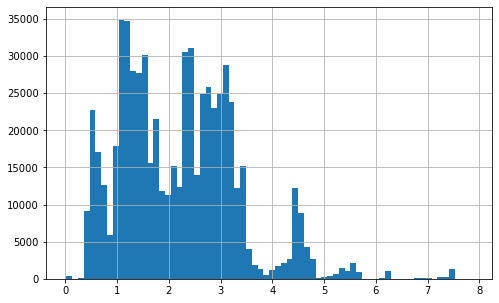

In [96]:
# Exploratory analysis
# plot(using a histogram) each column by seperating data into 50 bins
df['distance'].hist(bins=70, figsize=(8,5))
plt.show()

In [97]:
print(df.dtypes)

timestamp                      float64
hour                             int64
day                              int64
month                            int64
source                          object
destination                     object
cab_type                        object
product_id                      object
name                            object
price                          float64
distance                       float64
surge_multiplier               float64
latitude                       float64
longitude                      float64
temperature                    float64
apparentTemperature            float64
short_summary                   object
precipIntensity                float64
precipProbability              float64
humidity                       float64
windSpeed                      float64
windGust                       float64
windGustTime                     int64
visibility                     float64
temperatureHigh                float64
temperatureHighTime      

In [98]:
# one way to preparing your train and test data
# NOTE: a random train/test split could introduce sample bias
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [99]:
# the sampling bias is not that evident in this dataset
print(df.describe())
print("************")
print(df_train.describe())
print(df.head())

          timestamp           hour            day          month  \
count  6.379760e+05  637976.000000  637976.000000  637976.000000   
mean   1.544046e+09      11.618528      17.797674      11.586550   
std    6.892028e+05       6.948776       9.982083       0.492452   
min    1.543204e+09       0.000000       1.000000      11.000000   
25%    1.543444e+09       6.000000      13.000000      11.000000   
50%    1.543737e+09      12.000000      17.000000      12.000000   
75%    1.544828e+09      18.000000      28.000000      12.000000   
max    1.545161e+09      23.000000      30.000000      12.000000   

               price       distance  surge_multiplier       latitude  \
count  637976.000000  637976.000000     637976.000000  637976.000000   
mean       16.545125       2.189261          1.015068      42.338161   
std         9.324359       1.135413          0.095422       0.047856   
min         2.500000       0.020000          1.000000      42.214800   
25%         9.000000       

<AxesSubplot:>

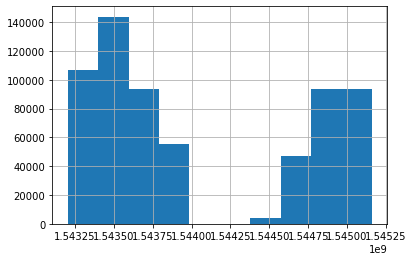

In [100]:
df["timestamp"].hist()

In [101]:
# identifying the correlation between features
# NOTE: if certain features are highly correlated, you can drop one of the correlated features to reduce the dimensionality of the feature space
corr_matrix = df.corr()
# print(corr_matrix)
print(corr_matrix['price'].sort_values(ascending=False))

price                          1.000000
distance                       0.345061
surge_multiplier               0.240458
latitude                       0.002088
visibility.1                   0.001497
visibility                     0.001497
windGust                       0.001218
precipIntensityMax             0.001114
windSpeed                      0.000990
month                          0.000913
cloudCover                     0.000883
pressure                       0.000866
windGustTime                   0.000851
apparentTemperatureLow         0.000831
apparentTemperatureMinTime     0.000814
timestamp                      0.000808
temperatureMinTime             0.000769
temperatureMaxTime             0.000766
uvIndexTime                    0.000763
apparentTemperatureLowTime     0.000761
sunsetTime                     0.000760
sunriseTime                    0.000760
temperatureHighTime            0.000759
temperatureLowTime             0.000754
apparentTemperatureMaxTime     0.000746


#### Model Development

In [102]:
# model development
# prepare the data
# drop label column(axis=1) from the training dataset
# remember that dataframes are mutable(i.e., reason for using .copy())
data = df_train.drop("price", axis=1) 
labels = df_train["price"].copy()

In [103]:
# check to see if there are any missing data
sample_incomplete_rows = data[data.isnull().any(axis=1)].head()
print(sample_incomplete_rows)
print(sample_incomplete_rows.shape)

Empty DataFrame
Columns: [timestamp, hour, day, month, source, destination, cab_type, product_id, name, distance, surge_multiplier, latitude, longitude, temperature, apparentTemperature, short_summary, precipIntensity, precipProbability, humidity, windSpeed, windGust, windGustTime, visibility, temperatureHigh, temperatureHighTime, temperatureLow, temperatureLowTime, apparentTemperatureHigh, apparentTemperatureHighTime, apparentTemperatureLow, apparentTemperatureLowTime, dewPoint, pressure, windBearing, cloudCover, uvIndex, visibility.1, ozone, sunriseTime, sunsetTime, moonPhase, precipIntensityMax, uvIndexTime, temperatureMin, temperatureMinTime, temperatureMax, temperatureMaxTime, apparentTemperatureMin, apparentTemperatureMinTime, apparentTemperatureMax, apparentTemperatureMaxTime]
Index: []

[0 rows x 51 columns]
(0, 51)


In [104]:
print(f"value counts:\n{df['source'].value_counts()}\n")
print(f"value counts:\n{df['destination'].value_counts()}\n")
print(f"value counts:\n{df['cab_type'].value_counts()}\n")
print(f"value counts:\n{df['product_id'].value_counts()}\n")
print(f"value counts:\n{df['short_summary'].value_counts()}\n")

# because the median is calculated on numerical data, we need to drop categorical features from the dataframe
rideshare_num = data.drop(['source','destination','cab_type','product_id','short_summary', "name"], axis=1)
print(rideshare_num.columns)

value counts:
Financial District         54197
Back Bay                   53201
Theatre District           53201
Boston University          53172
North End                  53171
Fenway                     53166
Northeastern University    53164
South Station              53160
Haymarket Square           53147
West End                   52980
Beacon Hill                52841
North Station              52576
Name: source, dtype: int64

value counts:
Financial District         54192
Back Bay                   53190
Theatre District           53189
Haymarket Square           53171
Boston University          53171
Fenway                     53166
Northeastern University    53165
North End                  53164
South Station              53159
West End                   52992
Beacon Hill                52840
North Station              52577
Name: destination, dtype: int64

value counts:
Uber    330568
Lyft    307408
Name: cab_type, dtype: int64

value counts:
6f72dfc5-27f1-42e8-84db-ccc7a75

In [105]:
# creating a pipeline so that you can chain together multiple steps
# NOTE: remember that the output from one step will be an inout to the other
# you can do these steps seperately and combine but Pipelines are more efficient
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(rideshare_num)
cat_attribs = ['source','destination','cab_type','product_id','short_summary', "name"]

# will be applying tranasformer object to the given subset of data
# NOTE: e.g., the "num_pipeline" transformer object will be applied on the given set of columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

 # sending the data through a chain of transformations
 # NOTE: the final dataset is a 2D numpy array containg all numerical data
rideshare_prepared = full_pipeline.fit_transform(data)
print(rideshare_prepared)

[[-0.43902292 -0.37610063 -1.58327596 ...  1.          0.
   0.        ]
 [ 1.12694399  1.35142318 -0.38093028 ...  0.          0.
   0.        ]
 [ 0.51316528  1.63934382 -0.88190765 ...  0.          0.
   0.        ]
 ...
 [-0.85113169 -1.38382285  1.12200182 ...  1.          0.
   0.        ]
 [ 0.97941487  0.77558191 -0.48112575 ...  0.          0.
   0.        ]
 [ 0.91543462 -1.09590222 -0.48112575 ...  0.          0.
   0.        ]]


In [106]:
# training a linear regression model
# NOTE: n_jobs -> number of processors to use for the computation (-1: indicates all the processors)
lin_reg = LinearRegression(n_jobs=-1)

# NOTE: we are using the transformed training data(housing_prepared) when training the model
lin_reg.fit(rideshare_prepared, labels)
some_data = data.iloc[:5]
some_labels = labels.iloc[:5]

# remember only to transform the data when preparing data for prediction
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Actual Labels:", list(some_labels))

Predictions: [ 9.94165039 34.60400391 28.73266602 12.95898438 13.26074219]
Actual Labels: [9.0, 32.5, 28.5, 11.0, 10.5]


In [108]:
# using a more powerful model to do the prediction
rf_reg = RandomForestRegressor(n_estimators=100, bootstrap=False, n_jobs=-1, verbose=1)
rf_reg.fit(rideshare_prepared, labels)
housing_predictions = rf_reg.predict(rideshare_prepared)
rf_rmse = mean_squared_error(labels, housing_predictions, squared=False)
# NOTE: we are using the transformed training data(housing_prepared) when training the model
rf_reg.fit(rideshare_prepared, labels)
some_data = data.iloc[:5]
some_labels = labels.iloc[:5]

# remember only to transform the data when preparing data for prediction
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", rf_reg.predict(some_data_prepared))
print("Actual Labels:", list(some_labels))

print(rf_rmse)
# train the model with different number of estimators
# 200 -> 18223
# 100 -> 18479
# 50 -> 18657
# 300 -> 18105
# bootstrap: True / False

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min


Predictions: [ 9.  32.5 28.5 11.  10.5]
Actual Labels: [9.0, 32.5, 28.5, 11.0, 10.5]
0.12456148508674511


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [109]:
# model development
# prepare the data
# drop label column(axis=1) from the training dataset
# remember that dataframes are mutable(i.e., reason for using .copy())
test_data = df_test.drop("price", axis=1) 
test_labels = df_test["price"].copy()

In [110]:
rideshare_prepared_test = full_pipeline.fit_transform(test_data)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


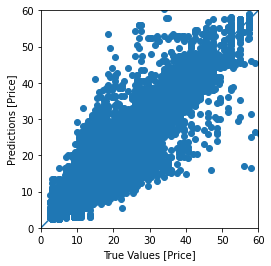

In [111]:
test_predictions = rf_reg.predict(rideshare_prepared_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 60]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

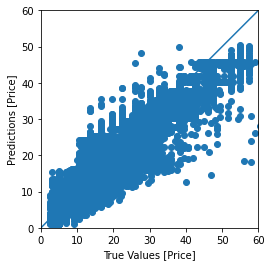

In [112]:
test_predictions = lin_reg.predict(rideshare_prepared_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 60]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)